<a href="https://colab.research.google.com/github/b-remy/score-estimation-comparison/blob/master/ScoreHMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Score Hamiltonian Monte-Carlo

In this notebook, we implement a version of Hamiltonian Monte-Carlo that only relies on having access to a score function, and never needs to evaluate the actual log posterior. 

## Step I: Computing MH acceptance with only scores

In this first section, we simply testing that we can indeed evaluate the MH step in HMC even if we only have access to the score. This can be done by integral over some integration path between step x_1 and x_2. 

I'm gonna link this for reference:  https://en.wikipedia.org/wiki/Line_integral

In [1]:
%pylab inline
import jax
import jax.numpy as np
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfd = tfp.distributions

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Let's use any old distribution
dist = tfd.MultivariateNormalDiag([0,0],scale_identity_multiplier=1)

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
# ok, so let's take 2 random points
x0 = np.array([0.1,0.2])
x1 = np.array([-1.5, 0.3])

In [4]:
# This is the quantity we want to estimate given only the score
dist.log_prob(x1) - dist.log_prob(x0) 

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


DeviceArray(-1.1450001, dtype=float32)

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


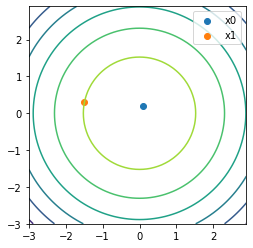

In [5]:
X = np.arange(-3, 3, 0.1)
Y = np.arange(-3, 3, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
contour(X,Y, dist.log_prob(points).reshape([len(Y), len(X)])); gca().set_aspect('equal')
scatter([x0[0]], [x0[1]], label='x0')
scatter([x1[0]], [x1[1]], label='x1')
legend()

In [6]:
# let's build our score function
score = jax.grad(lambda x: dist.log_prob(x))

In [7]:
# And let's try to integrate it
def integrand(t):
  # That's the path
  u = t * x1 + (1 - t) * x0 
  # That's the vector director of the integration path
  d = (x1 - x0)
  return d.dot(score(u))

In [8]:
# Ok, now we sample the score using many points
t = np.linspace(0,1,1024)
it = jax.vmap(integrand)(t)

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


In [9]:
from scipy.integrate import simps
# And integrate these samples
print("Path integral: %0.4f"%simps(it,t), "vs %0.4f"%(dist.log_prob(x1) - dist.log_prob(x0)))

Path integral: -1.1450 vs -1.1450


/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


In [10]:
# Magique!!!!

In [11]:
# Allright, let's see what happens if we have fewer steps
t = np.linspace(0,1,2)
it = jax.vmap(integrand)(t)

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


In [12]:
print("Path integral: %0.7f"%simps(it,t), "vs %0.7f"%(dist.log_prob(x1) - dist.log_prob(x0)))

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


Path integral: -1.1450000 vs -1.1450001


In [13]:
# Still good!

## Step II: Score-only Uncalibrated HMC 

So, we'll start by tricking TFP, providing a dummy log prob, returning always the same value, but having the correct score. In principle, UHMC should work because the actual value of logp is not needed.

In [104]:
from jax import custom_jvp

In [105]:
@custom_jvp
def mylogp(x):
  return 1.

@mylogp.defjvp
def mylogp_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  primal_out = mylogp(x)
  s = score(x)
  tangent_out = x_dot.dot(s)
  return primal_out, tangent_out

In [106]:
# Testing our gradients at x0
print("custom:", jax.value_and_grad(mylogp)(x0))
print("reference:", score(x0))

custom: (1.0, DeviceArray([-0.1, -0.2], dtype=float32))
reference: [-0.1 -0.2]


/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


In [107]:
print("custom:", jax.value_and_grad(mylogp)(x1))
print("reference:", score(x1))

custom: (1.0, DeviceArray([ 1.5, -0.3], dtype=float32))
reference: [ 1.5 -0.3]


/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


In [108]:
# Hhehehehehehe, TFP devrait n'y voir que du feux ^^

In [132]:
# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)

uhmc = tfp.mcmc.UncalibratedHamiltonianMonteCarlo(
        target_log_prob_fn=mylogp,
        num_leapfrog_steps=10,
        step_size=0.1)

In [133]:
# Run the chain (with burn-in).
samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=x1,
      kernel=uhmc,
      seed=jax.random.PRNGKey(0))

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/_jax/sample.py:314: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn('supplied `TransitionKernel` is not calibrated. Markov '
/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/_jax/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [134]:
samples.shape

(10000, 2)

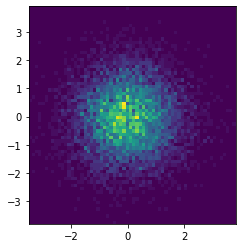

In [135]:
hist2d(samples[:,0], samples[:,1],64); gca().set_aspect('equal')

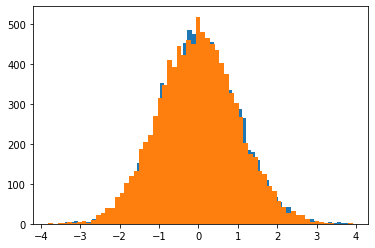

In [136]:
hist(samples[:,0],64);
hist(samples[:,1],64);

In [56]:
# Nickel!

## Step III: Score-only full HMC

In this section, we go beyond the prebious one and implement some form of estimate of delta_logp in order to use a Metropolis-Hastings step.

In [137]:
def simps(f, a, b, N=128):
    """Approximate the integral of f(x) from a to b by Simpson's rule.
    Simpson's rule approximates the integral \int_a^b f(x) dx by the sum:
    (dx/3) \sum_{k=1}^{N/2} (f(x_{2i-2} + 4f(x_{2i-1}) + f(x_{2i}))
    where x_i = a + i*dx and dx = (b - a)/N.
    Parameters
    ----------
    f : function
        Vectorized function of a single variable
    a , b : numbers
        Interval of integration [a,b]
    N : (even) integer
        Number of subintervals of [a,b]
    Returns
    -------
    float
        Approximation of the integral of f(x) from a to b using
        Simpson's rule with N subintervals of equal length.
    Examples
    --------
    >>> simps(lambda x : 3*x**2,0,1,10)
    1.0
    Notes:
    ------
    Stolen from: https://www.math.ubc.ca/~pwalls/math-python/integration/simpsons-rule/
    """
    if N % 2 == 1:
        raise ValueError("N must be an even integer.")
    dx = (b - a) / N
    x = np.linspace(a, b, N + 1)
    y = f(x)
    S = dx / 3 * np.sum(y[0:-1:2] + 4 * y[1::2] + y[2::2], axis=0)
    return S

In [249]:
class ScoreUHMC(tfp.mcmc.UncalibratedHamiltonianMonteCarlo):
  def __init__(self,
               target_score_fn,
               step_size,
               num_leapfrog_steps,
               num_delta_logp_steps,
               state_gradients_are_stopped=False,
               seed=None,
               store_parameters_in_results=False,
               name=None):
    
    # We begin by creating a fake logp, with the correct scores
    @custom_jvp
    def fake_logp(x):
      return 0.
    @fake_logp.defjvp
    def fake_logp_jvp(primals, tangents):
      x, = primals
      x_dot, = tangents
      primal_out = fake_logp(x)
      s = target_score_fn(x)
      tangent_out = x_dot.dot(s)
      return primal_out, tangent_out
    super().__init__(fake_logp,
                     step_size,
                     num_leapfrog_steps,
                     state_gradients_are_stopped,
                     seed,
                     store_parameters_in_results, name)
    self._parameters['target_score_fn'] = target_score_fn
    self._parameters['num_delta_logp_steps'] = num_delta_logp_steps

  def one_step(self, current_state, previous_kernel_results, seed=None):
    """
    Wrapper over the normal HMC steps 
    """
    next_state_parts, new_kernel_results = super().one_step(current_state, 
                                                            previous_kernel_results, 
                                                            seed)
    # We need to integrate the score over a path between input and output points
    # Direction of integration
    v = next_state_parts - current_state
    @jax.vmap
    def integrand(t):
      return self._parameters['target_score_fn']( t * v + current_state).dot(v)
    delta_logp = simps(integrand,0.,1., self._parameters['num_delta_logp_steps'])
    new_kernel_results2 = new_kernel_results._replace(log_acceptance_correction=new_kernel_results.log_acceptance_correction + delta_logp)
    return next_state_parts, new_kernel_results2

In [262]:
# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)

suhmc = ScoreUHMC(
        target_score_fn=score,
        num_leapfrog_steps=2,
        num_delta_logp_steps=16,
        step_size=0.4)

In [263]:
# Run the chain (with burn-in).
samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=x1,
      kernel=suhmc,
      seed=jax.random.PRNGKey(0))

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/_jax/sample.py:314: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn('supplied `TransitionKernel` is not calibrated. Markov '
/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/_jax/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


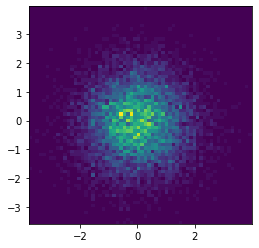

In [264]:
hist2d(samples[:,0], samples[:,1],64); gca().set_aspect('equal')

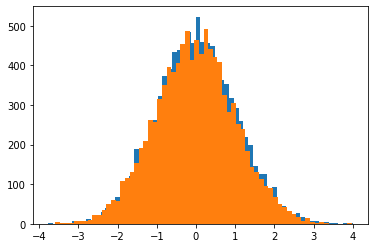

In [265]:
hist(samples[:,0],64);
hist(samples[:,1],64);

In [278]:
shmc = tfp.mcmc.MetropolisHastings(ScoreUHMC(
        target_score_fn=score,
        num_leapfrog_steps=2,
        num_delta_logp_steps=4,
        step_size=0.4))

In [279]:
# Run the chain (with burn-in).
samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=x0,
      kernel=shmc,
      seed=jax.random.PRNGKey(0))

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/_jax/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


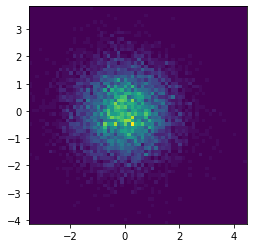

In [280]:
hist2d(samples[:,0], samples[:,1],64); gca().set_aspect('equal')

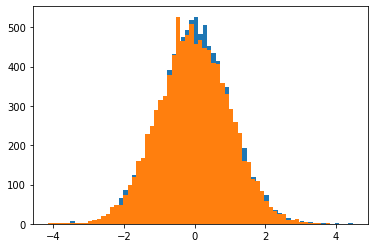

In [281]:
hist(samples[:,0],64);
hist(samples[:,1],64);

In [282]:
# Let's try a more complicated distribution

def get_two_moons(sigma, resolution=1024):
    """
    Returns two moons distribution as a TFP distribution
    Parameters
    ----------
    sigma: float
    Spread of the 2 moons distribution.
    resolution: int
    Number of components in the gaussian mixture approximation of the
    distribution (default: 1024)
    Returns
    -------
    distribution: TFP distribution
    Two moon distribution
    """

    outer_circ_x = np.cos(np.linspace(0, np.pi, resolution))
    outer_circ_y = np.sin(np.linspace(0, np.pi, resolution))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, resolution))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, resolution)) - .5

    X = np.append(outer_circ_x, inner_circ_x)
    Y = np.append(outer_circ_y, inner_circ_y)
    coords = np.vstack([X,Y])

    distribution = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=np.ones(2*resolution)/resolution/2),
    components_distribution=tfd.MultivariateNormalDiag(loc=coords.T, scale_identity_multiplier=sigma)
    )
    return distribution

In [321]:
dist = get_two_moons(0.05)

score = jax.grad(lambda x: dist.log_prob(x))

In [339]:
shmc = tfp.mcmc.MetropolisHastings( 
    ScoreUHMC(
        target_score_fn=score,
        num_leapfrog_steps=5,
        num_delta_logp_steps=8,
        step_size=0.1)
    )

In [340]:
# Run the chain (with burn-in).
samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=x0,
      kernel=shmc,
      trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(1))

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


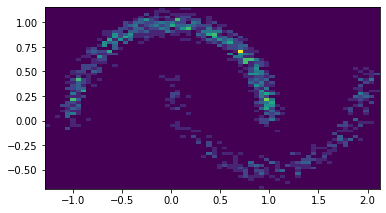

In [342]:
# Sampled from distribution with HMC :-D
hist2d(samples[is_accepted,0], samples[is_accepted,1],64); gca().set_aspect('equal')

In [344]:
len(where(is_accepted)[0])

1224

In [345]:
# For reference, let's draw from the input distribution
samples = dist.sample(10000, seed=jax.random.PRNGKey(1))

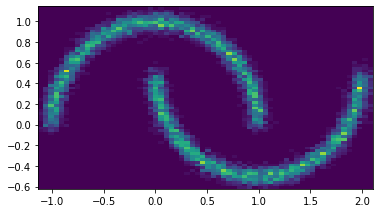

In [346]:
hist2d(samples[:,0], samples[:,1],64); gca().set_aspect('equal')

In [356]:
adaptive_hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=dist.log_prob,
        num_leapfrog_steps=5,
        step_size=0.1)
#    num_adaptation_steps=int(num_burnin_steps * 0.8))

In [358]:
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=x0,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(1))

/usr/local/lib/python3.6/dist-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


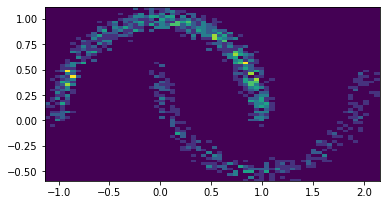

In [359]:
hist2d(samples[is_accepted,0], samples[is_accepted,1],64); gca().set_aspect('equal')